# Loan Prediction
Among all industries, the insurance domain has one of the largest uses of analytics & data science methods. This dataset provides you a taste of working on data sets from insurance companies – what challenges are faced there, what strategies are used, which variables influence the outcome, etc. This is a classification problem. The data has 615 rows and 13 columns.
<br>
<br>
<b>Problem:</b> Predict if a loan will get approved or not.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from classifiers import logisticRegression
from classifiers import DecisionTree
import progressbar
from time import sleep
%load_ext autoreload
%autoreload 2

# Load the Data

In [9]:
url = 'train_u6lujuX_CVtuZ9i.csv'
dataset = pd.read_csv(url)
dataset.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


# Data Clean-up

Let's begin our data clean-up with handling the Null values. Let's check how many columns have Null Values.

In [10]:
dataset.apply(lambda x:sum(x.isnull()),axis=0)

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

#### Dependents
let's start with the Dependents column. for the records where number of dependents are more then 3 the value is '3+'. This makes it a string value. Familiy size of 4, meaning 3 dependent, is a fair assumption. So lets update the values '3+' to integer value 3.

In [11]:
dataset.loc[dataset['Dependents'] == '3+','Dependents'] = 3
pd.to_numeric(dataset['Dependents'], errors='coerce')
dataset['Dependents'].value_counts()

0    345
1    102
2    101
3     51
Name: Dependents, dtype: int64

lets check how many Null values are there in Dependents column

In [12]:
dataset[dataset['Dependents'].isnull()].shape[0]

15

15 is not a big number. We can update it with the value for majority of records. Since, majority of records (345) have value 0. Lets update the null values with 0

In [13]:
dataset['Dependents'].fillna(0,inplace=True)
dataset['Dependents'] = dataset['Dependents'].astype(str).astype(int)
dataset[dataset['Dependents'].isnull()].shape[0]

0

#### Married
Next lets look at the Married column. Let's check how many Null values are there.

In [14]:
dataset[dataset['Married'].isnull()].shape[0]

3

Married column has only three Null Values. Lets update it with the value for the majority of the records

In [15]:
dataset['Married'].value_counts()

Yes    398
No     213
Name: Married, dtype: int64

Since majority of the records have value as 'Yes'. Let's update the null values as 'Yes'

In [16]:
dataset.loc[(dataset['Married'].isnull()),'Married'] = 'Yes'
dataset[dataset['Married'].isnull()].shape[0]

0

#### Self_Employed
Next let's look at Self_Employed column. We have 32 Null values. this column takes two values 'Yes' and 'No'. let's see what is the count for each of these values.

In [17]:
dataset['Self_Employed'].value_counts()

No     500
Yes     82
Name: Self_Employed, dtype: int64

Since majority of records have value No. Let's update the Null values with 'No'

In [18]:
dataset.loc[(dataset['Self_Employed'].isnull()),'Self_Employed'] = 'No'
dataset[dataset['Self_Employed'].isnull()].shape[0]

0

#### ApplicantIncome and Coapplicantincome
next we look at applicant income and co-applicant income. We can add these two values to get total income for the applicant.

In [19]:
dataset['total_income'] = dataset['ApplicantIncome'] + dataset['CoapplicantIncome']

Next let's look that the distribution for the total income. We create a histogram and a boxplot.

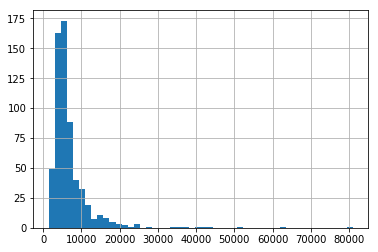

In [20]:
dataset['total_income'].hist(bins=50)

The total income looks right skewed. lets plot the box-plot also

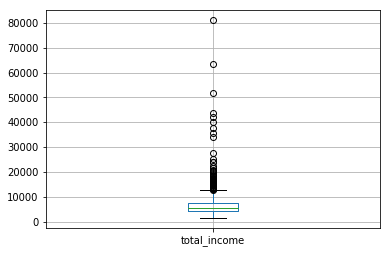

In [21]:
dataset.boxplot(column='total_income')

The Data seems to have a lot of outliers as well. in order to make total_income a bit cleaner, we can try two things
<br>
1) <b>Log Transform</b> :- this will help with righ-skewedness of the total_income
<br>
2) <b>Normalize the data</b>: since most of the feature are categorical in nature, we should normalize the total_income to fall in range 0 to 1. 

max_income 11.302204433654575
min_income 1442.0


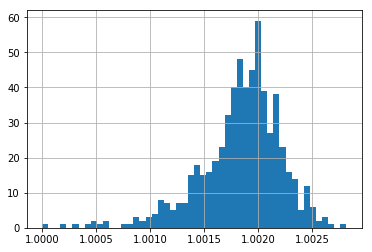

In [22]:
dataset['total_income_log'] = dataset['total_income'].apply(lambda x:np.log(x))
max_income = dataset['total_income_log'].max()
print('max_income',max_income)
min_income = dataset['total_income'].min()
print('min_income',min_income)
dataset['total_income_log'] = (dataset['total_income_log'] - min_income)/(max_income - min_income)
dataset['total_income_log'].hist(bins=50)

In [23]:
dataset['total_income_log'].describe()

count    614.000000
mean       1.001840
std        0.000381
min        1.000000
25%        1.001661
50%        1.001891
75%        1.002074
max        1.002816
Name: total_income_log, dtype: float64

#### Credit_History
For Credit history we have 50 Null records. But it's very hard to assess the value for the missing ones from the given data. So let's just drop those records from dataset

In [24]:
dataset =  dataset.dropna(subset=['Credit_History'])
dataset.shape

(564, 15)

#### Property_Area
Although this feature has no null value, it does take three distinct values - Rural, Semiurban, and Urban. We can split this into three sepearate dummy variables  

In [25]:
prop_dummy = pd.get_dummies(dataset['Property_Area'])
dataset = pd.concat([dataset,prop_dummy],axis=1)
dataset.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,total_income,total_income_log,Rural,Semiurban,Urban
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y,5849.0,1.001837,0,0,1
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N,6091.0,1.001809,1,0,0
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y,3000.0,1.002304,0,0,1
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y,4941.0,1.001955,0,0,1
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y,6000.0,1.001819,0,0,1


#### Degitize Categorical Features
Next let's ensure that the values for all the categorical variables are mapped to 0 or 1

In [26]:
dataset['Married'] = dataset['Married'].map({'Yes':1,'No':0})
dataset['Education'] = dataset['Education'].map({'Graduate':1,'Not Graduate':0})
dataset['Self_Employed'] = dataset['Self_Employed'].map({'Yes':1,'No':0})
dataset['Loan_Status'] = dataset['Loan_Status'].map({'Y':1,'N':0})
dataset.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,total_income,total_income_log,Rural,Semiurban,Urban
0,LP001002,Male,0,0,1,0,5849,0.0,NaN,360.0,1.0,Urban,1,5849.0,1.001837,0,0,1
1,LP001003,Male,1,1,1,0,4583,1508.0,128.0,360.0,1.0,Rural,0,6091.0,1.001809,1,0,0
2,LP001005,Male,1,0,1,1,3000,0.0,66.0,360.0,1.0,Urban,1,3000.0,1.002304,0,0,1
3,LP001006,Male,1,0,0,0,2583,2358.0,120.0,360.0,1.0,Urban,1,4941.0,1.001955,0,0,1
4,LP001008,Male,0,0,1,0,6000,0.0,141.0,360.0,1.0,Urban,1,6000.0,1.001819,0,0,1


#### Gender, loanAmount and Loan_Amount_Term
for this analysis let's drop these three columns. Let's take only one continuous feature for this analysis - total_income_log. we might include these two feature later on.

In [27]:
train_set = dataset[['Married','Dependents','Education','Self_Employed','total_income_log',
                    'Credit_History','Rural','Semiurban','Urban','Loan_Status']]
print('train_set.shape',train_set.shape)
train_set.head()

train_set.shape (564, 10)


,Married,Dependents,Education,Self_Employed,total_income_log,Credit_History,Rural,Semiurban,Urban,Loan_Status
0,0,0,1,0,1.001837,1.0,0,0,1,1
1,1,1,1,0,1.001809,1.0,1,0,0,0
2,1,0,1,1,1.002304,1.0,0,0,1,1
3,1,0,0,0,1.001955,1.0,0,0,1,1
4,0,0,1,0,1.001819,1.0,0,0,1,1


We are done with data cleaning! before we start our training let's cross check that none of the featurea have any Null values.

In [28]:
train_set.apply(lambda x:sum(x.isnull()),axis=0)

Married             0
Dependents          0
Education           0
Self_Employed       0
total_income_log    0
Credit_History      0
Rural               0
Semiurban           0
Urban               0
Loan_Status         0
dtype: int64

# Training
We are now ready to select a model and train it on the data. We will select following models for this problem
<br>
1) Logistics Regression
<br>
2) Decision Tree

### Logistics Regression
For this problem we will use the hand-build Logistics regression model

In [47]:
lg = logisticRegression()

training for lr: 0.0
Progress: |██████████████████████████████████████████████████| 100.0% Complete
For lr: 0.0  training auc: 0.5  validation auc: 0.5
training for lr: 0.01
Progress: |██████████████████████████████████████████████████| 100.0% Complete
For lr: 0.01  training auc: 0.8004319955406912  validation auc: 0.8602150537634408
training for lr: 0.1
Progress: |██████████████████████████████████████████████████| 100.0% Complete
For lr: 0.1  training auc: 0.7999303232998884  validation auc: 0.8591397849462366


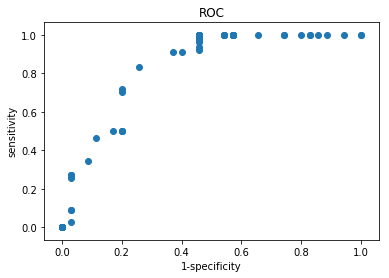

highest test auc: 0.8364468864468865  acheived for lr: 0.01


In [49]:
num_iter = 10000
learning_rate = np.array((0.0,0.01,0.1))
verbose = False
print_every = 1000
test_size = 0.2
kfold = 10
train_ds,test_ds = train_test_split(train_set,test_size = test_size)
test_arr = test_ds.values
test_x = np.hstack((np.ones((test_arr.shape[0],1)),test_arr[:,0:-1]))
test_y = test_arr[:,-1]
best_w = []
best_auc = 0.0
best_lr = 0.0
for lr in learning_rate:
    print('training for lr:',lr)
    w,auc = lg.fit(train_ds,num_iter,kfold,lr,print_every,verbose)
    if auc > best_auc:
        best_auc = auc
        best_w = w
        best_lr = lr
test_auc = lg.score(test_x,test_y,w,show_cm=True)
print('highest test auc:',test_auc,' acheived for lr:',best_lr)
#print('best w:',best_w)

Congratulation! ROC Area Under The Curve value of 80% and above is considered good. 

### Decision Tree
Logistics Regression performed reasonable well. Let's try one more classification model - Decision Tree. Again, we will hand craft it using numpy.

In [3]:
weather_dataset = pd.read_csv('weatherdata.csv')

In [4]:
weather_dataset.head()

,Outlook,Temperature,Humidity,Windy,Play
0,overcast,hot,high,False,yes
1,overcast,cool,normal,True,yes
2,overcast,mild,high,True,yes
3,overcast,hot,normal,False,yes
4,rainy,mild,high,False,yes


In [5]:
#dataset['Outlook'] = dataset['Outlook'].map({'overcast':1,'rainy':2,'sunny':3})
#dataset['Temperature'] = dataset['Temperature'].map({'hot':1,'mild':2,'cool':3})
#dataset['Humidity'] = dataset['Humidity'].map({'normal':1,'high':2})
#dataset['Windy'] = dataset['Windy'].map({False:0,True:1})
#dataset['Play'] = dataset['Play'].map({'yes':0,'no':1})
#dataset.head()

In [6]:
dt = DecisionTree()

In [7]:
dt.fit(weather_dataset)

Dtree [[0 'overcast' 0]
 [0 'rainy' 3]
 [0 'sunny' 2]
 [0 'overcast' -1]
 [3 False -1]
 [3 True -1]
 [2 'high' -1]
 [2 'normal' -1]]


let's try to use the Decision Tree on our Loan Prediction

In [76]:
url = 'train_u6lujuX_CVtuZ9i.csv'
dataset = pd.read_csv(url)
dataset.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [77]:
dataset.loc[dataset['Dependents'] == '3+','Dependents'] = 3
pd.to_numeric(dataset['Dependents'], errors='coerce')
dataset['Dependents'].fillna(0,inplace=True)
dataset['Dependents'] = dataset['Dependents'].astype(str).astype(int)

dataset.loc[(dataset['Married'].isnull()),'Married'] = 'Yes'

dataset.loc[(dataset['Self_Employed'].isnull()),'Self_Employed'] = 'No'

dataset['total_income'] = dataset['ApplicantIncome'] + dataset['CoapplicantIncome']

dataset['total_income_log'] = dataset['total_income'].apply(lambda x:np.log(x))
max_income = dataset['total_income_log'].max()
min_income = dataset['total_income_log'].min()
dataset['total_income_log'] = (dataset['total_income_log'] - min_income)/(max_income - min_income)

dataset =  dataset.dropna(subset=['Credit_History'])
dataset['total_income_cat'] = pd.cut(dataset['total_income_log'],bins=3,labels=['lower','middle','higher'])

train_set = dataset[['Married','Dependents','Education','Self_Employed','total_income_cat',
                    'Credit_History','Property_Area','Loan_Status']]

In [78]:
print('train_set.shape',train_set.shape)
train_set.head()

train_set.shape (564, 8)


,Married,Dependents,Education,Self_Employed,total_income_cat,Credit_History,Property_Area,Loan_Status
0,No,0,Graduate,No,middle,1.0,Urban,Y
1,Yes,1,Graduate,No,middle,1.0,Rural,N
2,Yes,0,Graduate,Yes,lower,1.0,Urban,Y
3,Yes,0,Not Graduate,No,lower,1.0,Urban,Y
4,No,0,Graduate,No,middle,1.0,Urban,Y


In [79]:
dt.fit(train_set)

Dtree [[5 0.0 -1]
 [5 1.0 6]
 [6 'Rural' -1]
 [6 'Semiurban' -1]
 [6 'Urban' -1]]


In [80]:
writer = pd.ExcelWriter('output.xlsx')
train_set.to_excel(writer,'Sheet1')
writer.save()

PermissionError: [Errno 13] Permission denied: 'output.xlsx'